In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import glob
import os
import seaborn as sns
import scipy
import glob
import sklearn 
from tqdm import tqdm


In [2]:
# Data for the first round of clustering
folder_name_1 = 'AE_Training_1'
file_name_1 = '21_Latent_Space'

# Location to save and load data for round 2 of clustering
folder_name_2 = 'AE_Training_2'
file_name_2 = '21_Latent_Space'

# Location of differently trained AE's for round 2 of clustering
# folder_name_3 = ''
# folder_name_4 = ''
# folder_name_5 = ''

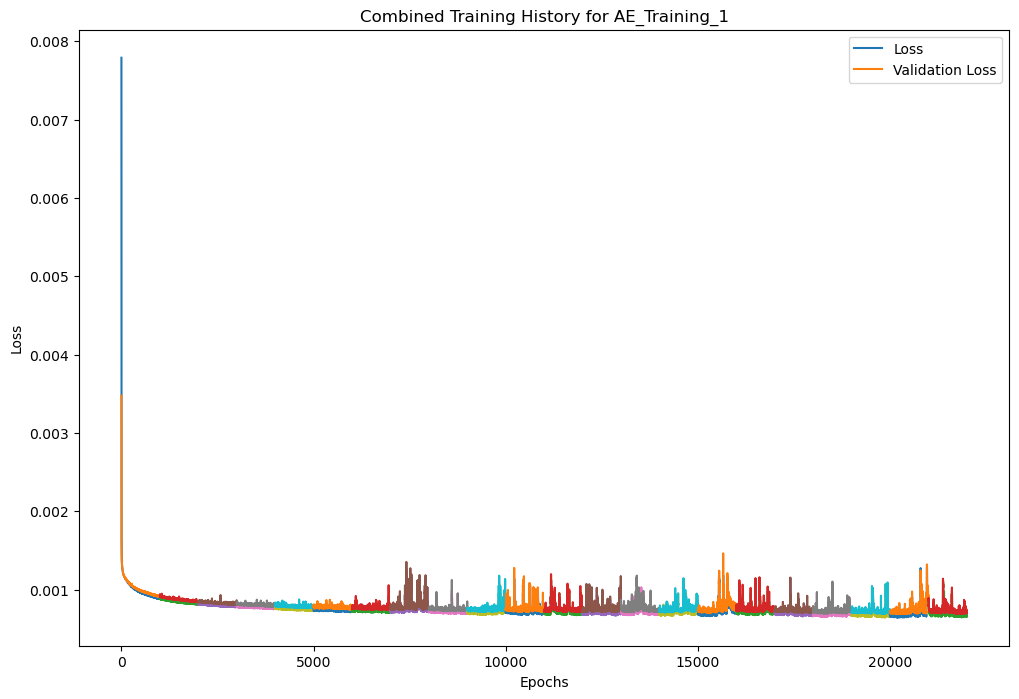

<Figure size 640x480 with 0 Axes>

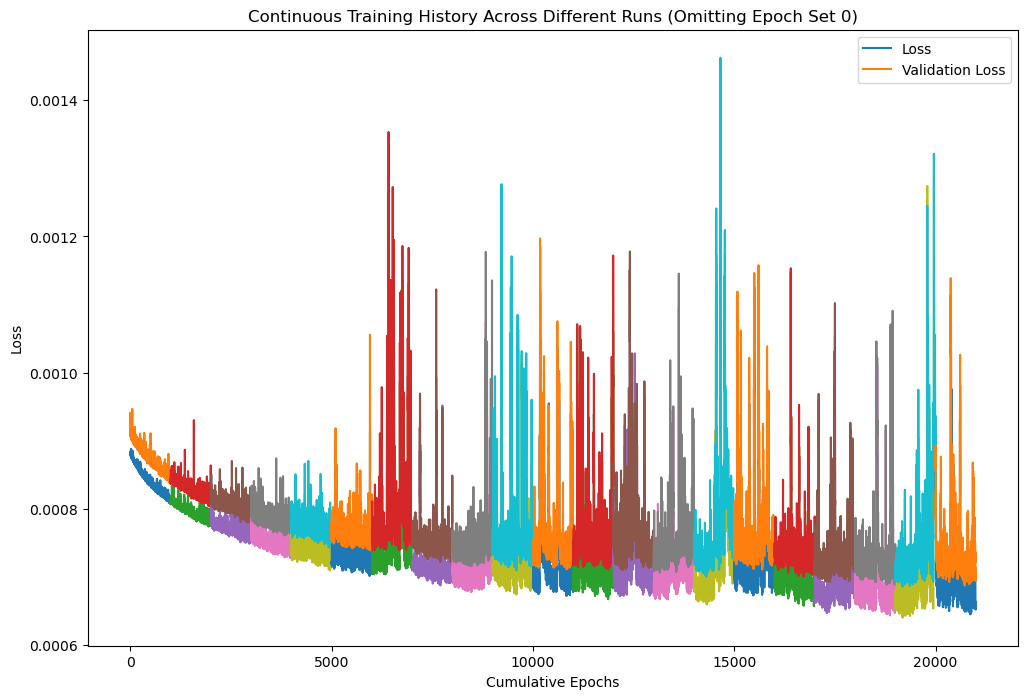

Minimum Loss: 0.000640 at Epoch 19181
Minimum Validation Loss: 0.000686 at Epoch 19181


<Figure size 640x480 with 0 Axes>

In [3]:
name = '_Autoencoder_Training_History' 

# Create a figure for plotting
plt.figure(figsize=(12, 8))

cumulative_epochs_1 = 0  # Variable to track the total number of epochs plotted

for count in range(22):  # 20 because range is exclusive on the upper bound
    file_name = os.path.join(folder_name_1, str(count) + name)
    try:
        # Load the training history file
        training_history = pd.read_pickle(file_name)
        
        # Number of epochs in the current training run
        num_epochs_1 = len(training_history)

        # Generate a range of epoch numbers for the current training run
        epoch_range_1 = range(cumulative_epochs_1, cumulative_epochs_1 + num_epochs_1)
        
        # Add labels only for the first epoch set
        if count == 0:
            loss_label = 'Loss'
            val_loss_label = 'Validation Loss'
        else:
            loss_label = None
            val_loss_label = None

        # Plot the training history with the adjusted epoch range
        plt.plot(epoch_range_1, training_history['loss'], label=loss_label)
        plt.plot(epoch_range_1, training_history['val_loss'], label=val_loss_label)

        # Update the cumulative number of epochs
        cumulative_epochs_1 += num_epochs_1

    except FileNotFoundError:
        print(f"File not found: {file_name}")

# Add labels
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Combined Training History for {folder_name_1}')

plt.show()

# Save the combined plot
# plt.savefig(os.path.join(folder_name_1, 'Combined_Training_History.png'), dpi=300)
plt.clf()  

# Figure 2: No Epoch Set 0

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Initialize variables to track the minimum loss and validation loss
min_loss = float('inf')
min_val_loss = float('inf')
min_loss_epoch = None
min_val_loss_epoch = None
cumulative_epochs_2 = 0

for count in range(1, 22):  # Starting from 1 to omit epoch set 0
    file_name = os.path.join(folder_name_1, str(count) + name)
    try:
        # Load the training history file
        training_history = pd.read_pickle(file_name)
        
        # Number of epochs in the current training run
        num_epochs_2 = len(training_history)

        # Generate a range of epoch numbers for the current training run
        epoch_range_2 = range(cumulative_epochs_2, cumulative_epochs_2 + num_epochs_2)

        # Plot the training history
        plt.plot(epoch_range_2, training_history['loss'], label='Loss' if count == 1 else None)
        plt.plot(epoch_range_2, training_history['val_loss'], label='Validation Loss' if count == 1 else None)

        # Check and update minimum loss and validation loss
        local_min_loss = training_history['loss'].min()
        local_min_val_loss = training_history['val_loss'].min()
        local_min_loss_epoch = training_history['loss'].idxmin()
        local_min_val_loss_epoch = training_history['val_loss'].idxmin()

        if local_min_loss < min_loss:
            min_loss = local_min_loss
            min_loss_epoch = local_min_loss_epoch + cumulative_epochs_2
        if local_min_val_loss < min_val_loss:
            min_val_loss = local_min_val_loss
            min_val_loss_epoch = local_min_val_loss_epoch + cumulative_epochs_2

        # Update the cumulative number of epochs
        cumulative_epochs_2 += num_epochs_2

    except FileNotFoundError:
        print(f"File not found: {file_name}")

# Add legend and labels
plt.legend()
plt.xlabel('Cumulative Epochs')
plt.ylabel('Loss')
plt.title('Continuous Training History Across Different Runs (Omitting Epoch Set 0)')

# Display the figure
plt.show()

# Optionally save the figure
# plt.savefig(os.path.join(folder_name_1, 'Continuous_Training_History_No_ES_0.png'), dpi=300)
plt.clf()  

# Print the minimum loss and validation loss with corresponding epochs
print(f"Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
print(f"Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

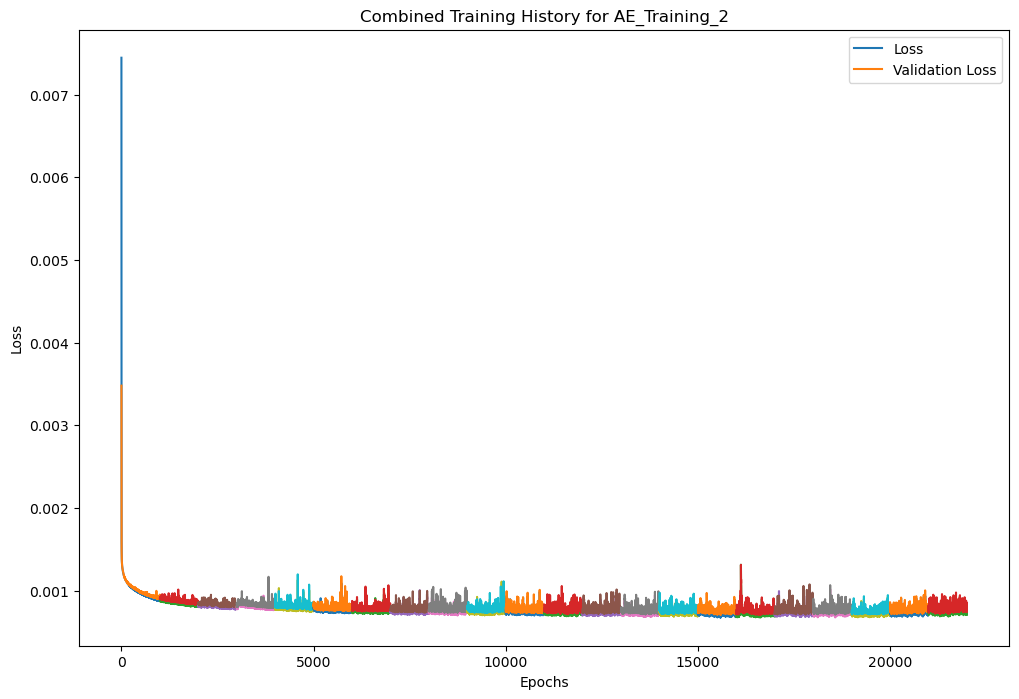

<Figure size 640x480 with 0 Axes>

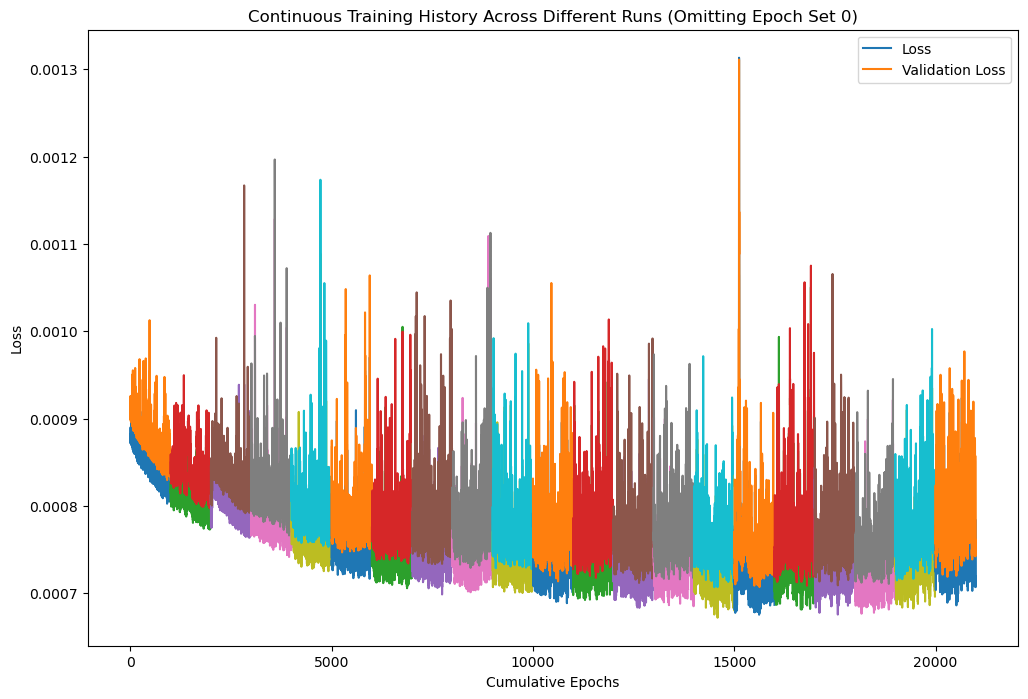

Minimum Loss: 0.000672 at Epoch 14586
Minimum Validation Loss: 0.000707 at Epoch 14507


<Figure size 640x480 with 0 Axes>

In [4]:
name = '_Autoencoder_Training_History' 

# Create a figure for plotting
plt.figure(figsize=(12, 8))

cumulative_epochs_1 = 0  # Variable to track the total number of epochs plotted

for count in range(22):  # 20 because range is exclusive on the upper bound
    file_name = os.path.join(folder_name_2, str(count) + name)
    try:
        # Load the training history file
        training_history = pd.read_pickle(file_name)
        
        # Number of epochs in the current training run
        num_epochs_1 = len(training_history)

        # Generate a range of epoch numbers for the current training run
        epoch_range_1 = range(cumulative_epochs_1, cumulative_epochs_1 + num_epochs_1)
        
        # Add labels only for the first epoch set
        if count == 0:
            loss_label = 'Loss'
            val_loss_label = 'Validation Loss'
        else:
            loss_label = None
            val_loss_label = None

        # Plot the training history with the adjusted epoch range
        plt.plot(epoch_range_1, training_history['loss'], label=loss_label)
        plt.plot(epoch_range_1, training_history['val_loss'], label=val_loss_label)

        # Update the cumulative number of epochs
        cumulative_epochs_1 += num_epochs_1

    except FileNotFoundError:
        print(f"File not found: {file_name}")

# Add labels
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Combined Training History for {folder_name_2}')

plt.show()

# Save the combined plot
# plt.savefig(os.path.join(folder_name_1, 'Combined_Training_History.png'), dpi=300)
plt.clf()  

# Figure 2: No Epoch Set 0

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Initialize variables to track the minimum loss and validation loss
min_loss = float('inf')
min_val_loss = float('inf')
min_loss_epoch = None
min_val_loss_epoch = None
cumulative_epochs_2 = 0

for count in range(1, 22):  # Starting from 1 to omit epoch set 0
    file_name = os.path.join(folder_name_2, str(count) + name)
    try:
        # Load the training history file
        training_history = pd.read_pickle(file_name)
        
        # Number of epochs in the current training run
        num_epochs_2 = len(training_history)

        # Generate a range of epoch numbers for the current training run
        epoch_range_2 = range(cumulative_epochs_2, cumulative_epochs_2 + num_epochs_2)

        # Plot the training history
        plt.plot(epoch_range_2, training_history['loss'], label='Loss' if count == 1 else None)
        plt.plot(epoch_range_2, training_history['val_loss'], label='Validation Loss' if count == 1 else None)

        # Check and update minimum loss and validation loss
        local_min_loss = training_history['loss'].min()
        local_min_val_loss = training_history['val_loss'].min()
        local_min_loss_epoch = training_history['loss'].idxmin()
        local_min_val_loss_epoch = training_history['val_loss'].idxmin()

        if local_min_loss < min_loss:
            min_loss = local_min_loss
            min_loss_epoch = local_min_loss_epoch + cumulative_epochs_2
        if local_min_val_loss < min_val_loss:
            min_val_loss = local_min_val_loss
            min_val_loss_epoch = local_min_val_loss_epoch + cumulative_epochs_2

        # Update the cumulative number of epochs
        cumulative_epochs_2 += num_epochs_2

    except FileNotFoundError:
        print(f"File not found: {file_name}")

# Add legend and labels
plt.legend()
plt.xlabel('Cumulative Epochs')
plt.ylabel('Loss')
plt.title('Continuous Training History Across Different Runs (Omitting Epoch Set 0)')

# Display the figure
plt.show()

# Optionally save the figure
# plt.savefig(os.path.join(folder_name_1, 'Continuous_Training_History_No_ES_0.png'), dpi=300)
plt.clf()  

# Print the minimum loss and validation loss with corresponding epochs
print(f"Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
print(f"Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

## Clustering

In [5]:
# read in and plot the original data set
latent = pd.read_pickle(f'{folder_name_1}/20_Latent_Space')
latent = latent.replace({'trajectory-0.0': '0', 'trajectory-1.0': '1'}).infer_objects()

In [6]:
# Set the 'index' column as the new index
latent.set_index('index', inplace=True)

# Remove the name of the new index
latent.index.name = None

In [7]:
print(latent)

              x         y  z
11480 -7.586531  0.567537  0
69241 -7.923385  0.059725  1
23321 -5.473639 -1.834530  0
79963 -1.314996  0.128874  1
53139 -7.460699 -2.068390  1
...         ...       ... ..
54086 -6.610475 -1.813323  1
58314 -3.577525 -0.962358  1
16642 -2.664897 -3.951708  0
10766 -6.024659 -2.030483  0
11205 -7.369310  0.902473  0

[16000 rows x 3 columns]


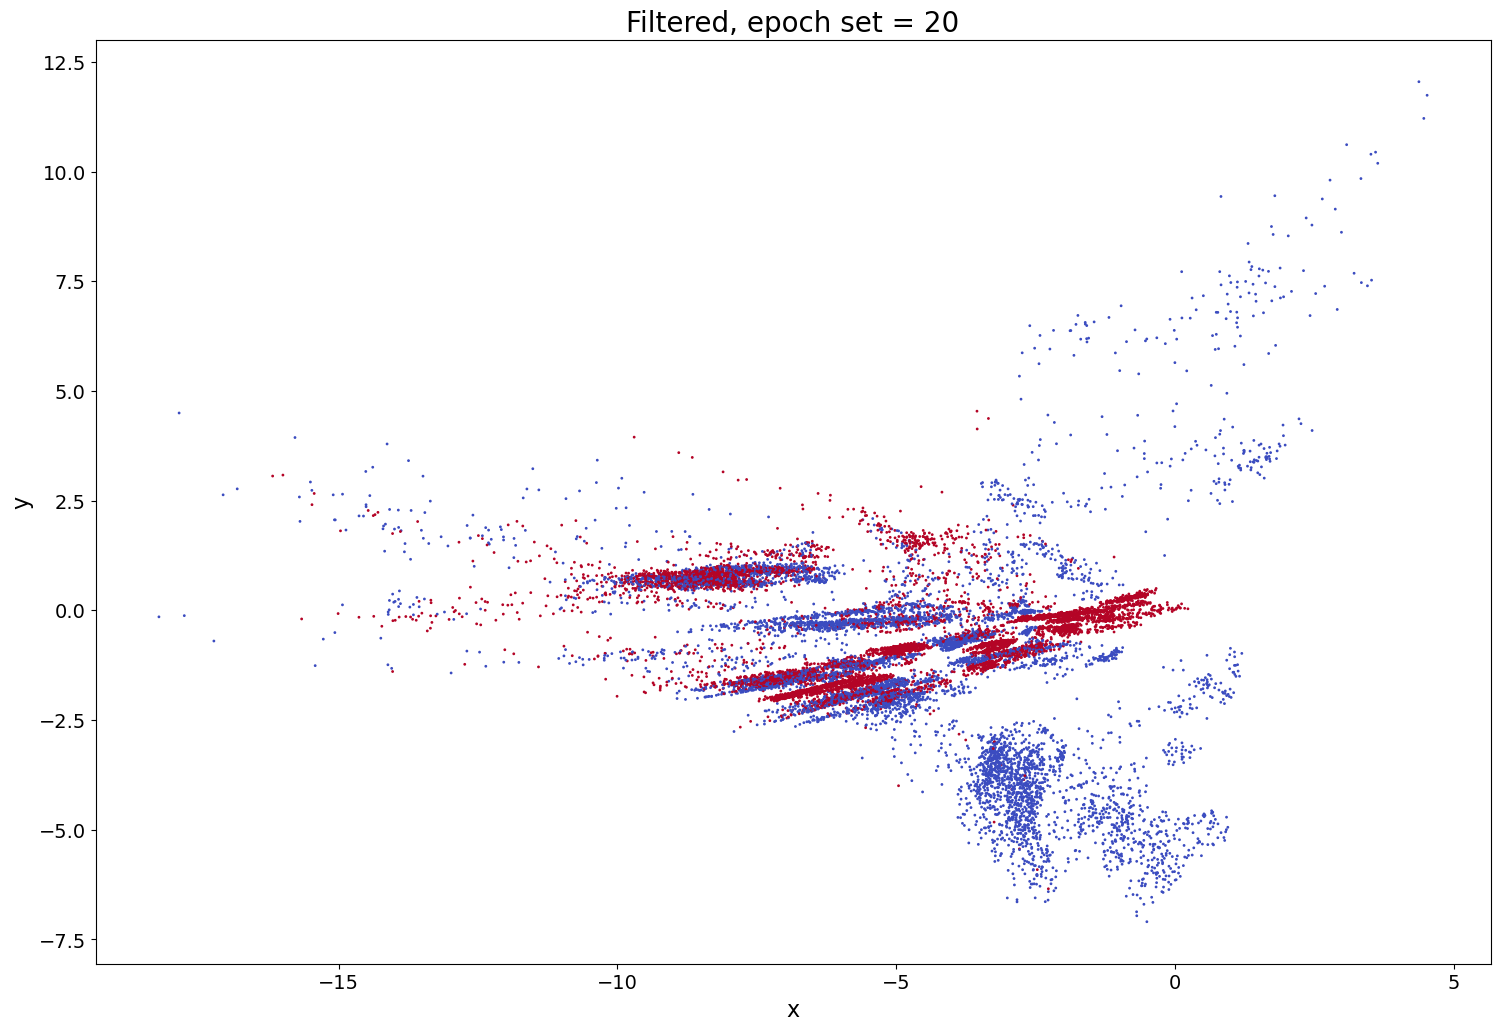

In [8]:
latent['z'] = pd.to_numeric(latent['z'], errors='coerce')

plt.figure(figsize=(18,12))
plt.scatter (latent.x,latent.y, c=latent.z, cmap="coolwarm", s = 1, alpha=1)
plt.title('Filtered, epoch set = 20', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
# plt.savefig("56_data.png", dpi = 300)

plt.show()

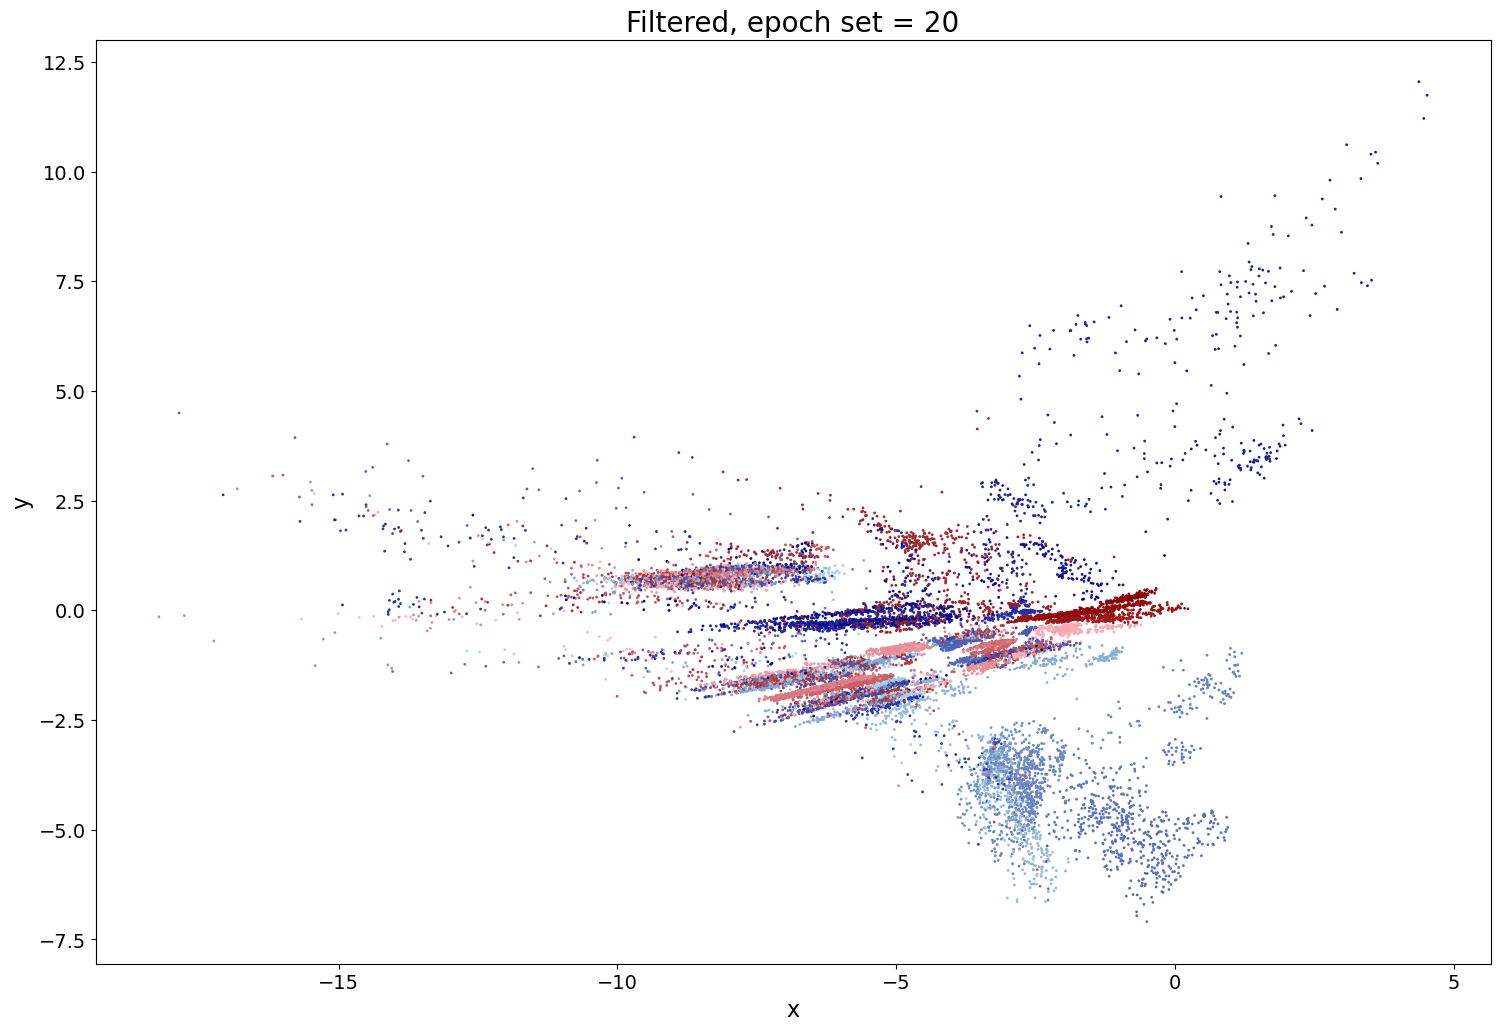

In [9]:
from matplotlib.colors import LinearSegmentedColormap

# Convert the index to a Series and rank the indices
ranked_indices = pd.Series(latent.index).rank(method='dense').astype(int) - 1
normalized_ranks = ranked_indices / ranked_indices.max()

# Create two colormaps: one for blue shades and one for red shades
blue_cmap = LinearSegmentedColormap.from_list("blue_shades", ["lightblue", "darkblue"], N=40000)
red_cmap = LinearSegmentedColormap.from_list("red_shades", ["lightpink", "darkred"], N=40000)

# Function to apply the correct color based on normalized rank
def apply_colormap(norm_rank):
    if norm_rank < 0.5:
        return blue_cmap(norm_rank * 2)  # Normalize rank to 0-1 range for blue
    else:
        return red_cmap((norm_rank - 0.5) * 2)  # Normalize rank to 0-1 range for red

# Apply the colormap to each point based on its normalized rank
colors = [apply_colormap(nr) for nr in normalized_ranks]

plt.figure(figsize=(18, 12))
plt.scatter(latent['x'], latent['y'], c=colors, s=1, alpha=1)
plt.title('Filtered, epoch set = 20', fontsize=20)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig("color_coded_data.png", dpi=300)

plt.show()

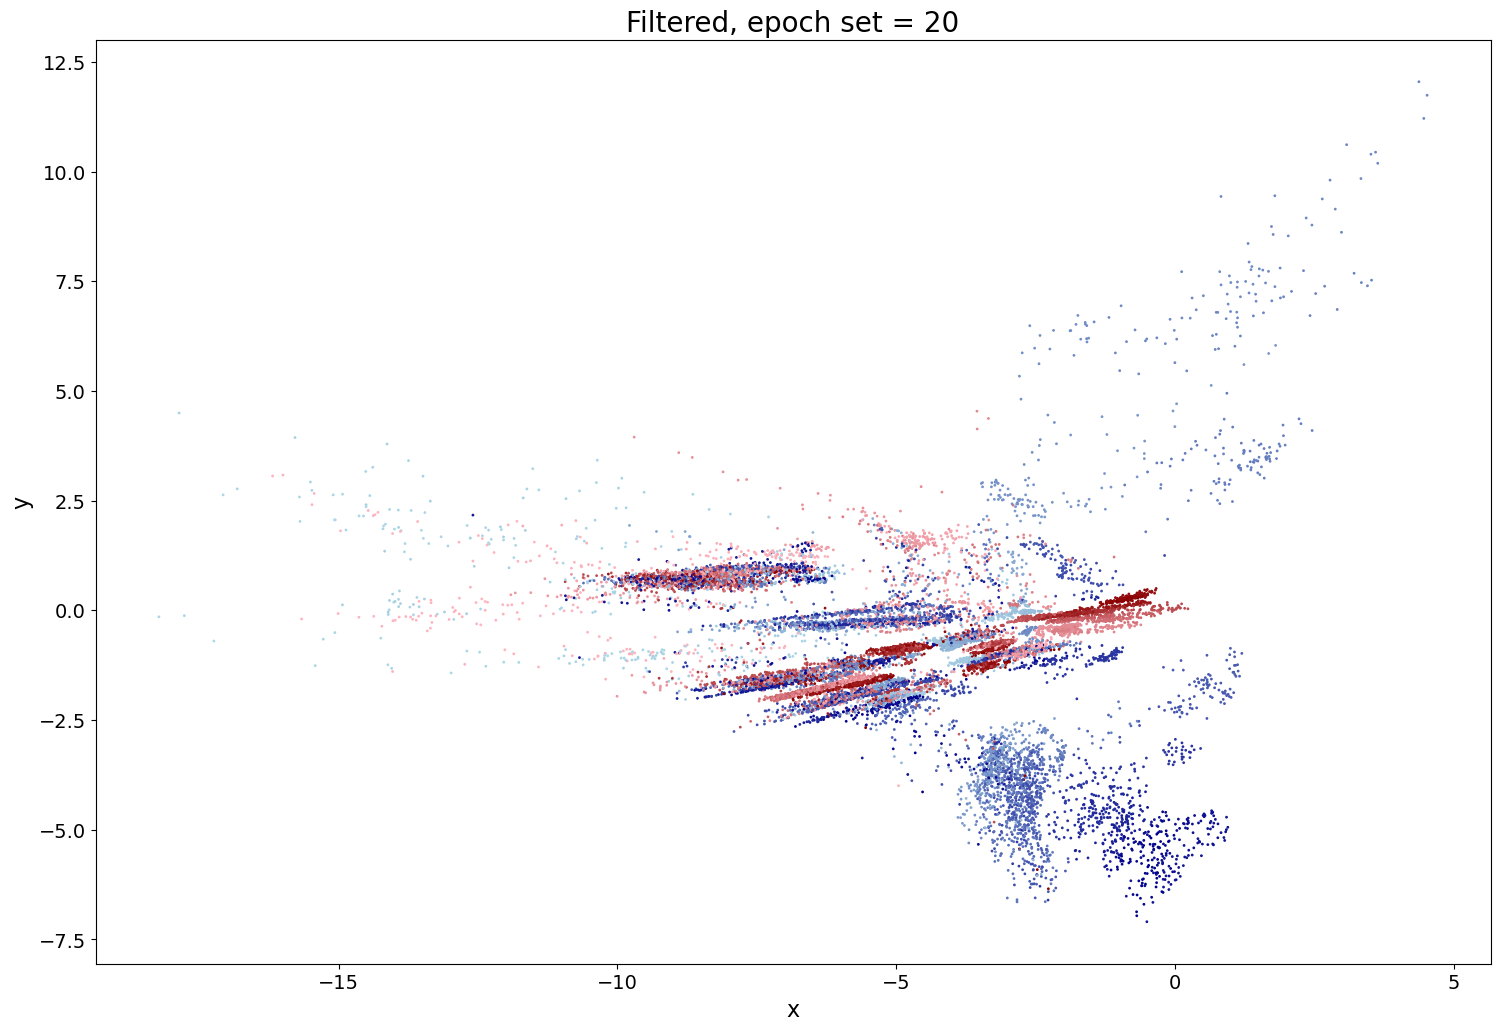

In [10]:


# Assuming latent is a DataFrame with 'x' and 'y' columns and indices

# Convert the index to a Series and rank the indices
ranked_indices = pd.Series(latent.index).rank(method='dense').astype(int) - 1
normalized_ranks = ranked_indices / ranked_indices.max()

# Create colormaps for 10,000 increments
def create_increment_cmap(start_color, end_color, increments):
    return LinearSegmentedColormap.from_list(f"cmap_{start_color}_{end_color}", [start_color, end_color], N=increments)

# Define the colormaps
blue_cmap = create_increment_cmap("lightblue", "darkblue", 10000)
red_cmap = create_increment_cmap("lightpink", "darkred", 10000)

# Function to apply the correct color based on index
def apply_colormap(index):
    if index < 40000:
        # Blue shades for indices 0-39999 in 10000 increments
        increment_index = index % 10000
        return blue_cmap(increment_index / 10000)
    else:
        # Red shades for indices 40000-79999 in 10000 increments
        increment_index = (index - 40000) % 10000
        return red_cmap(increment_index / 10000)

# Apply the colormap to each point based on its index
colors = [apply_colormap(idx) for idx in latent.index]

plt.figure(figsize=(18, 12))
plt.scatter(latent['x'], latent['y'], c=colors, s=1, alpha=1)
plt.title('Filtered, epoch set = 20', fontsize=20)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig("color_coded_data.png", dpi=300)

plt.show()


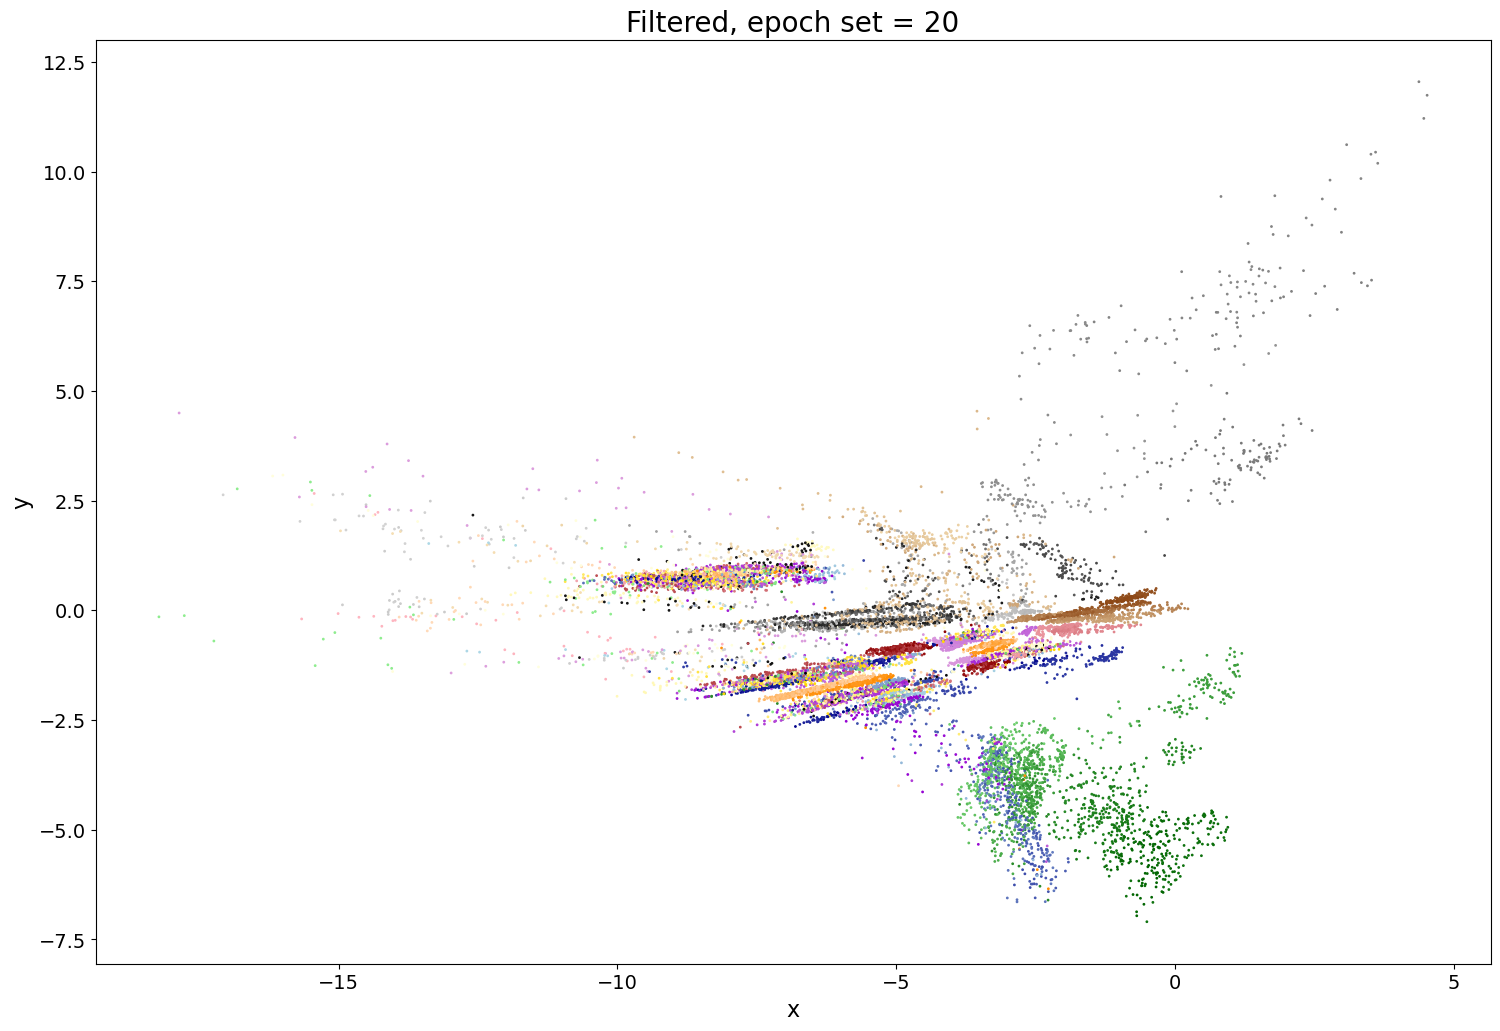

In [11]:

# Convert the index to a Series and rank the indices
ranked_indices = pd.Series(latent.index).rank(method='dense').astype(int) - 1
normalized_ranks = ranked_indices / ranked_indices.max()

# Create colormaps for 10,000 increments
def create_increment_cmap(start_color, end_color, increments):
    return LinearSegmentedColormap.from_list(f"cmap_{start_color}_{end_color}", [start_color, end_color], N=increments)

# Define the colormaps for each range
colormaps = [
    create_increment_cmap("lightblue", "darkblue", 10000),
    create_increment_cmap("lightgreen", "darkgreen", 10000),
    create_increment_cmap("plum", "darkviolet", 10000),
    create_increment_cmap("lightgrey", "black", 10000),
    create_increment_cmap("lightpink", "darkred", 10000),
    create_increment_cmap("peachpuff", "darkorange", 10000),
    create_increment_cmap("lightyellow", "gold", 10000),
    create_increment_cmap("wheat", "saddlebrown", 10000)
]

# Function to apply the correct color based on index
def apply_colormap(index):
    range_index = index // 10000
    if range_index >= len(colormaps):
        range_index = len(colormaps) - 1  # Cap to the last colormap if out of bounds
    increment_index = index % 10000
    return colormaps[range_index](increment_index / 10000)

# Apply the colormap to each point based on its index
colors = [apply_colormap(idx) for idx in latent.index]

plt.figure(figsize=(18, 12))
plt.scatter(latent['x'], latent['y'], c=colors, s=1, alpha=1)
plt.title('Filtered, epoch set = 20', fontsize=20)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig("color_coded_data.png", dpi=300)

plt.show()


In [12]:
# remove the trajectory identity column for further processing
latent_n = latent.drop(['z'], axis = 1)

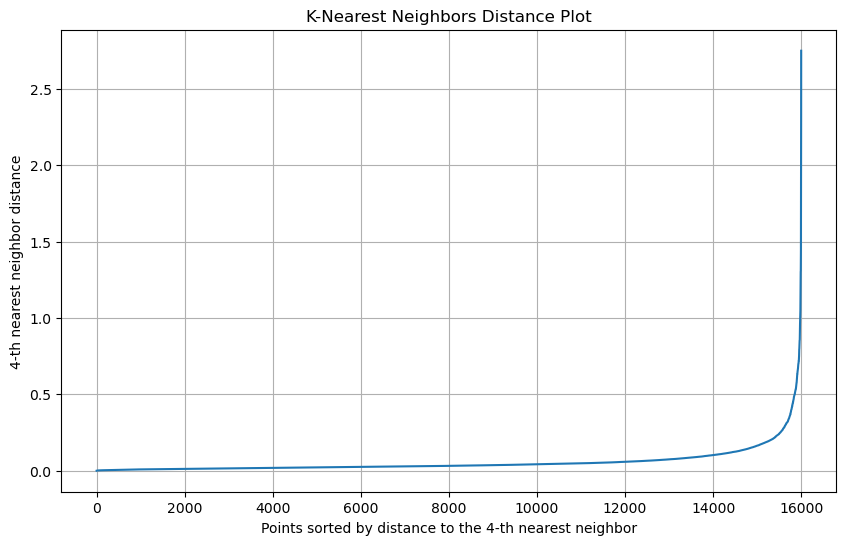

In [13]:
def plot_knn_distances(latent_n, k=4):
    """
    Plot the k-nearest neighbors distance for each point in the dataset to help
    determine a good 'eps' value for DBSCAN.

    Parameters:
    - data: The dataset (as a numpy array or similar).
    - k: The number of neighbors to consider (typically the same as 'min_samples' in DBSCAN).
    """
    # Compute the nearest neighbors
    nn = NearestNeighbors(n_neighbors=k).fit(latent_n)
    distances, _ = nn.kneighbors(latent_n)

    # Sort and plot the distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances)
    plt.xlabel('Points sorted by distance to the {}-th nearest neighbor'.format(k))
    plt.ylabel('{}-th nearest neighbor distance'.format(k))
    plt.title('K-Nearest Neighbors Distance Plot')
    plt.grid(True)
    plt.show()

# Then call the function with your data
# plot_knn_distances(df55.values, k=4) 


plot_knn_distances(latent.values, k=4)  # Adjust 'k' as needed

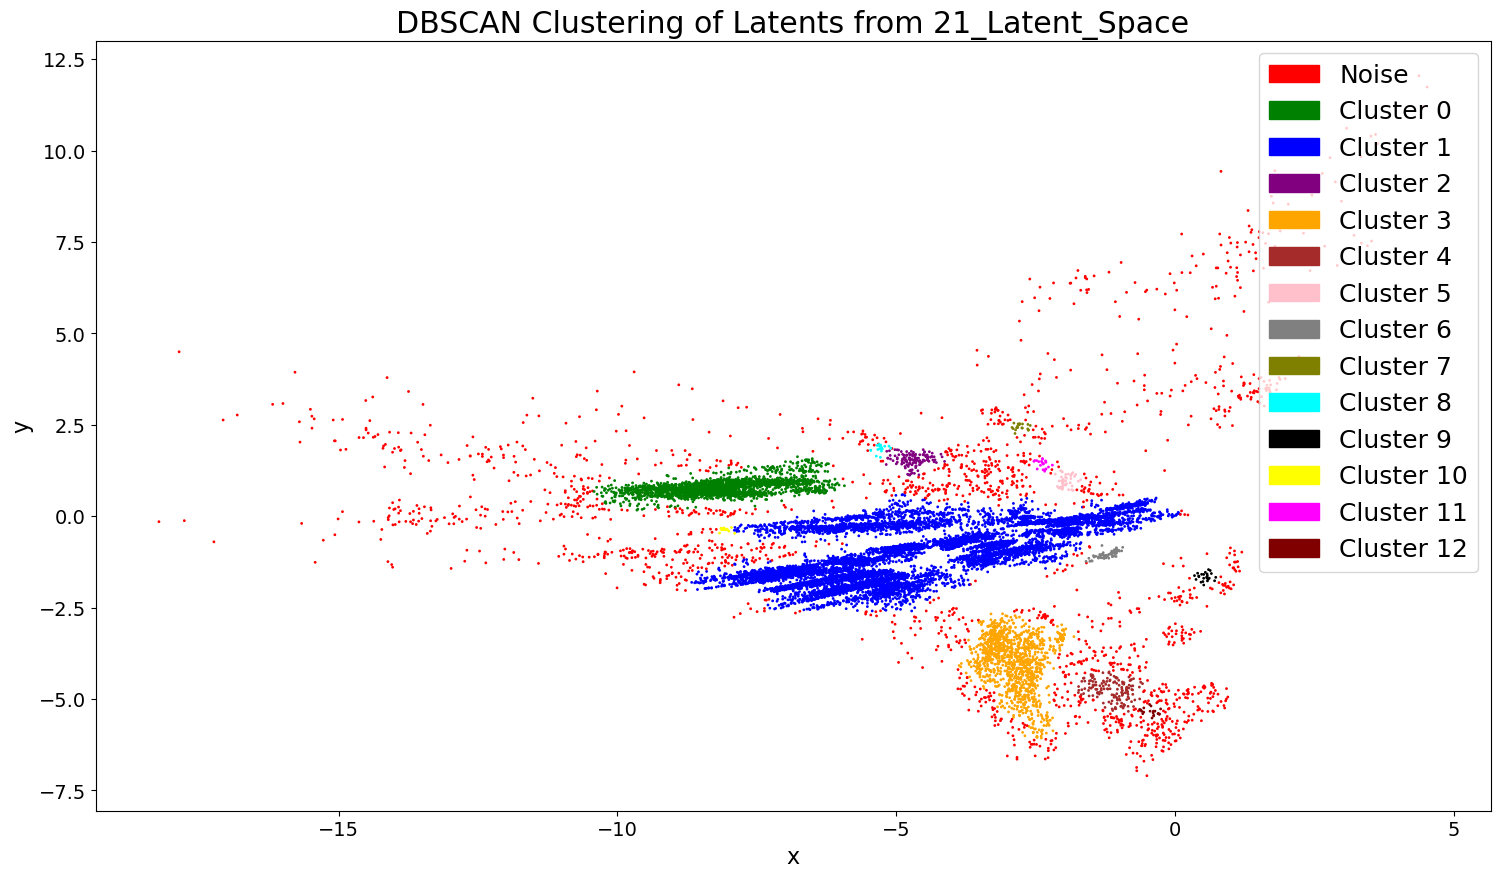

Number of clusters: 13


In [14]:
y_pred = DBSCAN(eps=0.20, min_samples=20).fit_predict(latent_n)

plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,10))

# Define a custom color palette
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black', 'yellow', 'magenta', 'maroon', 'navy']

# Creating a mapping for cluster labels to colors
unique_labels = np.unique(y_pred)
label_color_map = {lbl: colors[i] for i, lbl in enumerate(unique_labels)}

# Map y_pred to the defined colors
cluster_colors = [label_color_map[label] for label in y_pred]

# Scatter plot using the custom colors
plt.scatter(latent_n.iloc[:,0], latent_n.iloc[:,1], c=cluster_colors, s=1)

# Creating a legend
legend_handles = [mpatches.Patch(color=label_color_map[lbl], label=f'Cluster {lbl}' if lbl != -1 else 'Noise') for lbl in unique_labels]

plt.legend(handles=legend_handles, loc='upper right')

# Setting labels, titles, and ticks
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'DBSCAN Clustering of Latents from {file_name_1}')
# png_path = os.path.join(folder_name_2, f'{file_name_1}_Original_Cluster_All.png')
# plt.savefig(png_path, dpi=300)
plt.show()

# Print the number of clusters
print('Number of clusters: {}'.format(len(unique_labels[unique_labels != -1])))

In [15]:
# latent_n is DataFrame after removing the 'z' column
# latent is the original DataFrame with the 'z' column

# Add the cluster labels to your DataFrame
latent_n['cluster'] = y_pred
latent['cluster'] = y_pred

# Reattach the 'z' column
latent_n['z'] = latent['z']

# Group by cluster and trajectory identity, then count the occurrences
cluster_trajectory_count = latent_n.groupby(['cluster', 'z']).size().reset_index(name='count')

print(cluster_trajectory_count)

    cluster  z  count
0        -1  0   1409
1        -1  1    426
2         0  0    948
3         0  1   1374
4         1  0   4175
5         1  1   6064
6         2  0     22
7         2  1    110
8         3  0   1104
9         3  1      8
10        4  0    148
11        5  0     37
12        5  1      4
13        6  0     57
14        7  0     19
15        7  1      1
16        8  0      6
17        8  1     11
18        9  0     24
19       10  0     13
20       11  0     18
21       11  1      2
22       12  0     20


/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


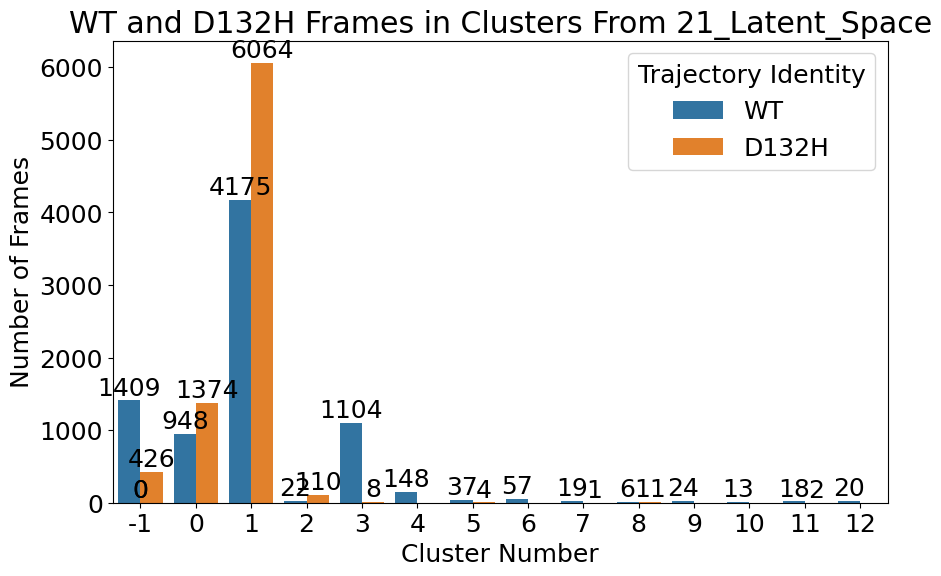

In [16]:
# 0 is WT and 1 is D132H
cluster_trajectory_count['z'] = cluster_trajectory_count['z'].replace({0: 'WT', 1: 'D132H'})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='count', hue='z', data=cluster_trajectory_count)

# Setting labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Frames')
plt.title(f'WT and D132H Frames in Clusters From {file_name_1}')
plt.xticks(rotation=0)
plt.legend(title='Trajectory Identity')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()

In [17]:
# Create a dictionary to hold the indices for each cluster
cluster_indices = {}

# Loop through each unique cluster label
for cluster_label in np.unique(y_pred):
    # Extract indices of the datapoints belonging to the current cluster
    indices = latent_n[latent_n['cluster'] == cluster_label].index.tolist()
    # Store these indices in the dictionary
    cluster_indices[cluster_label] = indices

# Print the summary of indices for each cluster
for cluster_label, indices in cluster_indices.items():
    print(f"Cluster {cluster_label}: {len(indices)} datapoints")
    print(f"Indices: {indices}\n")

Cluster -1: 1835 datapoints
Indices: [69241, 20042, 33015, 20409, 70316, 32961, 13687, 60117, 28680, 32134, 4537, 18455, 33373, 17408, 30139, 36889, 36099, 19048, 63021, 33844, 18907, 20231, 33134, 10075, 1530, 32411, 25682, 18281, 19831, 70771, 34151, 19152, 17267, 70041, 38709, 60155, 32518, 39602, 13364, 60110, 73505, 18901, 32215, 19511, 5545, 36588, 70960, 10194, 34060, 70525, 71842, 15725, 71828, 33012, 30302, 32309, 17315, 30350, 70998, 32257, 5743, 36302, 33956, 20404, 34250, 17698, 19843, 20387, 10156, 33602, 14741, 34443, 16085, 33727, 32931, 34044, 60109, 37605, 16045, 10064, 72657, 70689, 5922, 33815, 36578, 38703, 71283, 36292, 30355, 40034, 15641, 50163, 17295, 40176, 14237, 36515, 30259, 19195, 18375, 15968, 19671, 18377, 20204, 40060, 34067, 25691, 7904, 36033, 15965, 10196, 70580, 19554, 15758, 30040, 32183, 70923, 33404, 30646, 17357, 17334, 36629, 5648, 31940, 40011, 30005, 61725, 13557, 18113, 30386, 40157, 70308, 70046, 28774, 34130, 61479, 17587, 73439, 10124, 138

# Custering Round 2

In [18]:
# read in and plot the original data set
latent_2 = pd.read_pickle(f'{folder_name_2}/20_Latent_Space')
latent_2 = latent_2.replace({'trajectory-0.0': '0', 'trajectory-1.0': '1'}).infer_objects()

In [19]:
# Set the 'index' column as the new index
latent_2.set_index('index', inplace=True)

# Remove the name of the new index
latent_2.index.name = None

In [20]:
print(latent_2)

              x          y  z
11480  2.672355  -9.491482  0
69241  2.405004 -10.683020  1
23321  1.136191  -3.892785  0
79963 -0.192164  -0.628538  1
53139  3.787285  -9.573817  1
...         ...        ... ..
54086  3.544936  -8.958076  1
58314  2.075577  -6.903740  1
16642  0.640360  -7.930159  0
10766  2.509474  -8.662283  0
11205  2.673645  -9.002752  0

[16000 rows x 3 columns]


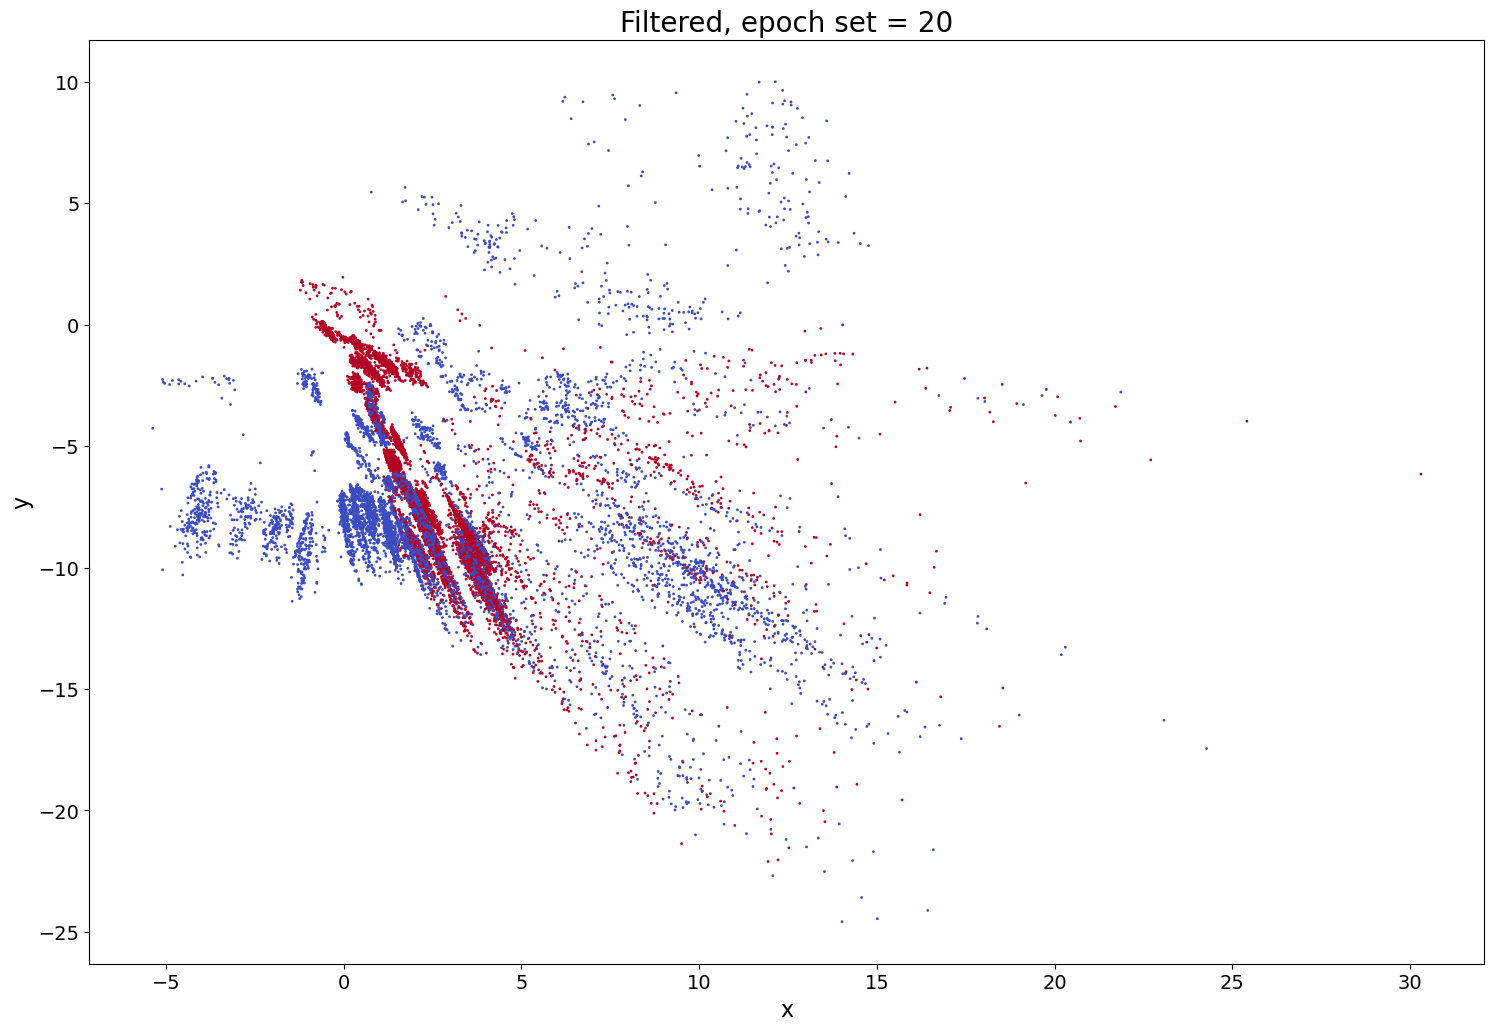

In [21]:
latent_2['z'] = pd.to_numeric(latent_2['z'], errors='coerce')

plt.figure(figsize=(18,12))
plt.scatter (latent_2.x,latent_2.y, c=latent_2.z, cmap="coolwarm", s = 1, alpha=1)
plt.title('Filtered, epoch set = 20', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
# plt.savefig("56_data.png", dpi = 300)

plt.show()

In [22]:
# remove the trajectory identity column for further processing
latent_2n = latent_2.drop(['z'], axis = 1)

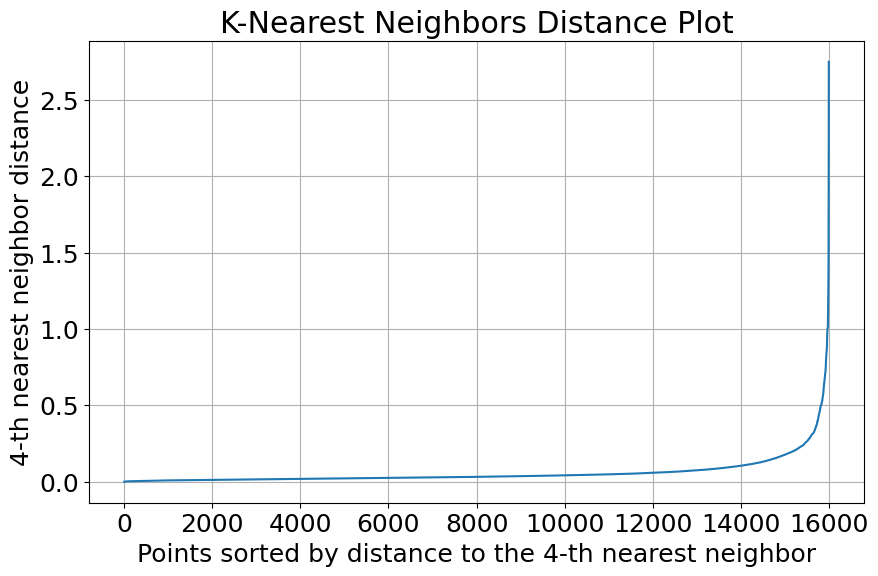

In [23]:
def plot_knn_distances(latent_2n, k=4):
    """
    Plot the k-nearest neighbors distance for each point in the dataset to help
    determine a good 'eps' value for DBSCAN.

    Parameters:
    - data: The dataset (as a numpy array or similar).
    - k: The number of neighbors to consider (typically the same as 'min_samples' in DBSCAN).
    """
    # Compute the nearest neighbors
    nn = NearestNeighbors(n_neighbors=k).fit(latent_2n)
    distances, _ = nn.kneighbors(latent_2n)

    # Sort and plot the distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances)
    plt.xlabel('Points sorted by distance to the {}-th nearest neighbor'.format(k))
    plt.ylabel('{}-th nearest neighbor distance'.format(k))
    plt.title('K-Nearest Neighbors Distance Plot')
    plt.grid(True)
    plt.show()

# Then call the function with your data
# plot_knn_distances(df55.values, k=4) 


plot_knn_distances(latent.values, k=4)  # Adjust 'k' as needed

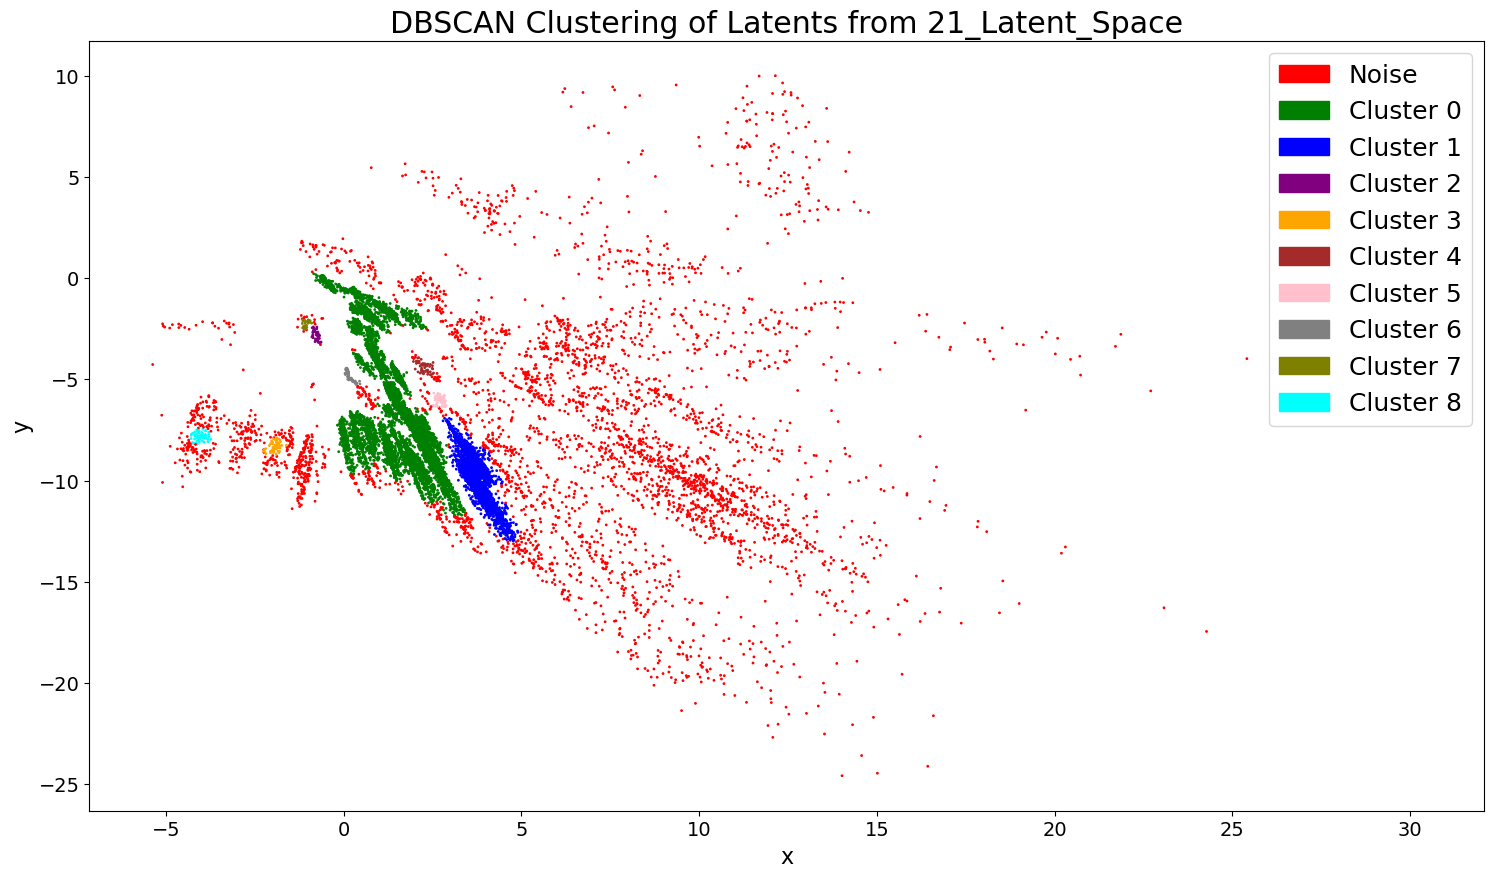

Number of clusters: 9


In [24]:
y_pred = DBSCAN(eps=0.20, min_samples=20).fit_predict(latent_2n)

plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,10))

# Define a custom color palette
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black', 'yellow', 'magenta', 'maroon', 'navy']

# Creating a mapping for cluster labels to colors
unique_labels = np.unique(y_pred)
label_color_map = {lbl: colors[i] for i, lbl in enumerate(unique_labels)}

# Map y_pred to the defined colors
cluster_colors = [label_color_map[label] for label in y_pred]

# Scatter plot using the custom colors
plt.scatter(latent_2n.iloc[:,0], latent_2n.iloc[:,1], c=cluster_colors, s=1)

# Creating a legend
legend_handles = [mpatches.Patch(color=label_color_map[lbl], label=f'Cluster {lbl}' if lbl != -1 else 'Noise') for lbl in unique_labels]

plt.legend(handles=legend_handles, loc='upper right')

# Setting labels, titles, and ticks
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'DBSCAN Clustering of Latents from {file_name_2}')
# png_path = os.path.join(folder_name_2, f'{file_name_1}_Original_Cluster_All.png')
# plt.savefig(png_path, dpi=300)
plt.show()

# Print the number of clusters
print('Number of clusters: {}'.format(len(unique_labels[unique_labels != -1])))

In [25]:
# latent_n is DataFrame after removing the 'z' column
# latent is the original DataFrame with the 'z' column

# Add the cluster labels to your DataFrame
latent_2n['cluster'] = y_pred
latent_2['cluster'] = y_pred

# Reattach the 'z' column
latent_2n['z'] = latent['z']

# Group by cluster and trajectory identity, then count the occurrences
cluster_trajectory_count = latent_2n.groupby(['cluster', 'z']).size().reset_index(name='count')

print(cluster_trajectory_count)

    cluster  z  count
0        -1  0   2719
1        -1  1   1180
2         0  0   4068
3         0  1   4785
4         1  0    864
5         1  1   2029
6         2  0     40
7         3  0     58
8         4  0     63
9         5  0     47
10        5  1      6
11        6  0     56
12        7  0     29
13        8  0     56


/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


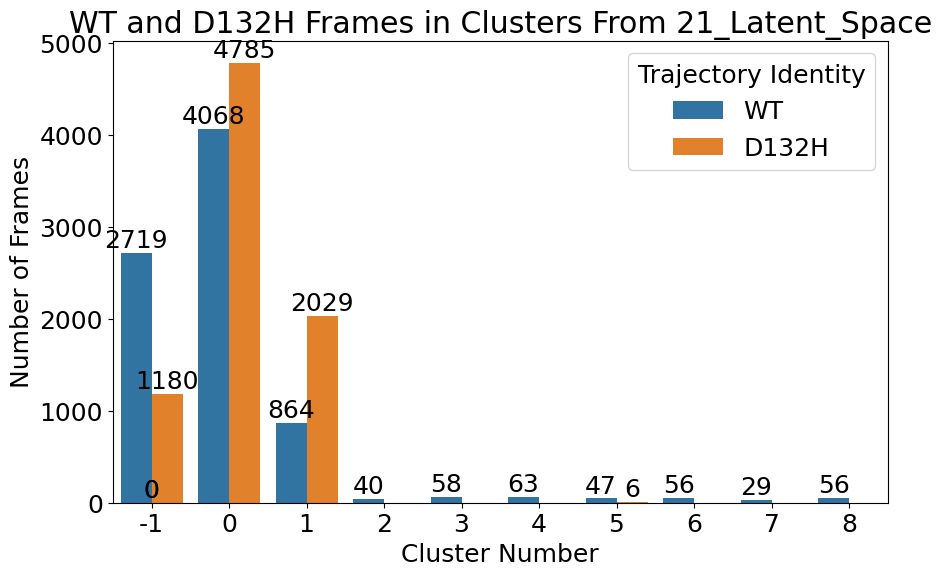

In [26]:
# 0 is WT and 1 is D132H
cluster_trajectory_count['z'] = cluster_trajectory_count['z'].replace({0: 'WT', 1: 'D132H'})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='count', hue='z', data=cluster_trajectory_count)

# Setting labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Frames')
plt.title(f'WT and D132H Frames in Clusters From {file_name_2}')
plt.xticks(rotation=0)
plt.legend(title='Trajectory Identity')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()

In [27]:
# Create a dictionary to hold the indices for each cluster
b_cluster_indices = {}

# Loop through each unique cluster label
for cluster_label in np.unique(y_pred):
    # Extract indices of the datapoints belonging to the current cluster
    b_indices = latent_2n[latent_2n['cluster'] == cluster_label].index.tolist()
    # Store these indices in the dictionary
    b_cluster_indices[cluster_label] = b_indices

# Print the summary of indices for each cluster
for cluster_label, b_indices in b_cluster_indices.items():
    print(f"Cluster {cluster_label}: {len(b_indices)} datapoints")
    print(f"Indices: {b_indices}\n")

Cluster -1: 3899 datapoints
Indices: [30606, 20042, 33015, 38357, 70316, 32961, 73184, 60117, 32563, 32134, 4537, 18455, 36312, 33373, 61365, 30139, 20291, 36889, 36099, 14005, 60100, 19048, 36307, 60040, 31420, 71026, 33844, 18907, 20231, 33134, 10075, 71347, 32411, 38168, 18281, 19831, 37286, 70771, 49877, 34151, 37903, 19152, 72445, 72273, 61331, 70041, 36971, 31060, 72329, 72253, 38709, 38586, 60155, 32518, 72341, 37680, 30937, 72731, 37106, 41148, 34512, 37256, 18433, 37456, 36269, 71222, 60110, 39086, 73484, 4260, 50362, 32806, 35238, 73505, 10535, 18901, 31606, 32215, 35370, 38090, 19511, 36588, 70960, 71935, 70228, 10194, 38344, 34060, 70525, 35503, 35314, 20450, 30795, 73324, 68659, 71842, 71828, 33012, 30302, 70436, 32309, 72867, 17798, 17315, 72897, 30350, 70998, 31799, 71944, 72111, 31639, 38569, 31140, 36907, 4127, 5743, 34797, 38137, 36302, 46066, 72443, 33956, 35934, 72527, 34250, 73105, 73639, 37529, 34808, 19843, 20387, 35854, 7298, 29850, 10156, 33602, 71839, 14741, 4

# Consistent Index Extraction:

In [29]:
# Assuming y_pred is used for clustering both Data 1 and Data 2
# Create a dictionary to hold the indices for each cluster in Data 1
cluster_indices = {}
for cluster_label in np.unique(latent_n['cluster']):
    indices = latent_n[latent_n['cluster'] == cluster_label].index.tolist()
    cluster_indices[cluster_label] = indices

# Create a dictionary to hold the indices for each cluster in Data 2
b_cluster_indices = {}
for cluster_label in np.unique(latent_2n['cluster']):
    b_indices = latent_2n[latent_2n['cluster'] == cluster_label].index.tolist()
    b_cluster_indices[cluster_label] = b_indices

# Find the common indices between the clusters in Data 1 and Data 2
common_indices = {}

for cluster_label in cluster_indices.keys():
    if cluster_label in b_cluster_indices:
        # Find common indices in both clusters
        common = set(cluster_indices[cluster_label]).intersection(set(b_cluster_indices[cluster_label]))
        if common:
            common_indices[cluster_label] = list(common)

# Print the summary of common indices for each cluster
for cluster_label, indices in common_indices.items():
    print(f"Cluster {cluster_label}: {len(indices)} common datapoints")
    print(f"Common Indices: {indices}\n")



Cluster -1: 1495 common datapoints
Common Indices: [3, 8, 12, 28, 29, 40991, 65575, 41, 65578, 43, 44, 41003, 47, 65583, 32817, 50, 48, 54, 68, 73, 76, 77, 16467, 16471, 32857, 91, 16476, 16477, 16480, 32868, 32871, 32881, 32882, 32883, 32893, 32894, 32899, 32902, 32903, 32912, 32922, 32927, 32928, 32931, 32935, 32937, 32938, 32940, 32948, 32950, 32954, 32961, 32972, 32974, 32977, 32979, 32980, 32988, 32994, 32999, 33011, 33012, 33014, 33015, 33025, 33032, 33035, 33040, 33051, 33053, 33054, 33065, 33066, 33082, 33086, 33093, 33096, 33100, 33113, 33114, 33134, 33159, 33161, 33164, 33183, 33185, 33193, 33194, 33197, 33200, 33201, 33208, 33214, 33215, 33229, 33234, 33239, 33242, 33244, 33248, 33249, 33250, 33253, 33254, 33255, 33258, 33263, 33265, 33277, 33278, 33286, 33292, 33314, 33318, 33319, 33328, 33329, 33330, 33336, 33339, 33345, 33347, 33356, 33362, 33367, 33371, 33373, 33375, 33376, 33378, 33379, 33382, 33389, 33391, 33394, 33396, 33398, 33404, 33418, 33420, 33422, 33429, 33457, 

In [30]:
import numpy as np
from scipy.optimize import linear_sum_assignment

# Create a dictionary to hold the indices for each cluster in Data 1
cluster_indices = {}
for cluster_label in np.unique(latent_n['cluster']):
    indices = latent_n[latent_n['cluster'] == cluster_label].index.tolist()
    cluster_indices[cluster_label] = indices

# Create a dictionary to hold the indices for each cluster in Data 2
b_cluster_indices = {}
for cluster_label in np.unique(latent_2n['cluster']):
    b_indices = latent_2n[latent_2n['cluster'] == cluster_label].index.tolist()
    b_cluster_indices[cluster_label] = b_indices

# Get the list of cluster labels
cluster_labels_1 = list(cluster_indices.keys())
cluster_labels_2 = list(b_cluster_indices.keys())

# Compute the overlap matrix
overlap_matrix = np.zeros((len(cluster_labels_1), len(cluster_labels_2)))

for i, label1 in enumerate(cluster_labels_1):
    for j, label2 in enumerate(cluster_labels_2):
        overlap = len(set(cluster_indices[label1]).intersection(set(b_cluster_indices[label2])))
        overlap_matrix[i, j] = -overlap  # Negative because linear_sum_assignment finds minimum cost

# Apply the Hungarian algorithm to find the best match
row_ind, col_ind = linear_sum_assignment(overlap_matrix)

# Retain only the common indices according to the best match
common_indices = {}

for i, j in zip(row_ind, col_ind):
    label1 = cluster_labels_1[i]
    label2 = cluster_labels_2[j]
    common = set(cluster_indices[label1]).intersection(set(b_cluster_indices[label2]))
    if common:
        common_indices[(label1, label2)] = list(common)

# Print the summary of common indices for each matched cluster pair
for (label1, label2), indices in common_indices.items():
    print(f"Matched Cluster {label1} (Data 1) and Cluster {label2} (Data 2): {len(indices)} common datapoints")
    print(f"Common Indices: {indices}\n")


Matched Cluster -1 (Data 1) and Cluster -1 (Data 2): 1495 common datapoints
Common Indices: [3, 8, 12, 28, 29, 40991, 65575, 41, 65578, 43, 44, 41003, 47, 65583, 32817, 50, 48, 54, 68, 73, 76, 77, 16467, 16471, 32857, 91, 16476, 16477, 16480, 32868, 32871, 32881, 32882, 32883, 32893, 32894, 32899, 32902, 32903, 32912, 32922, 32927, 32928, 32931, 32935, 32937, 32938, 32940, 32948, 32950, 32954, 32961, 32972, 32974, 32977, 32979, 32980, 32988, 32994, 32999, 33011, 33012, 33014, 33015, 33025, 33032, 33035, 33040, 33051, 33053, 33054, 33065, 33066, 33082, 33086, 33093, 33096, 33100, 33113, 33114, 33134, 33159, 33161, 33164, 33183, 33185, 33193, 33194, 33197, 33200, 33201, 33208, 33214, 33215, 33229, 33234, 33239, 33242, 33244, 33248, 33249, 33250, 33253, 33254, 33255, 33258, 33263, 33265, 33277, 33278, 33286, 33292, 33314, 33318, 33319, 33328, 33329, 33330, 33336, 33339, 33345, 33347, 33356, 33362, 33367, 33371, 33373, 33375, 33376, 33378, 33379, 33382, 33389, 33391, 33394, 33396, 33398, 3